# CNN-Based Rotation Correction - Advanced Machine Learning Project

### Matteo Breganni 869549

# Imports

In [4]:
from google.colab import drive
import zipfile
import shutil
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import math
import seaborn as sns
import json

import random as random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
cv2.setRNGSeed(0)
rng = np.random.default_rng(0)

# Dataset Preparation

In [5]:
#shutil.rmtree("dataset")

## Dataset Creation, Set Partitioning and Images Split

The dataset is split between train, val and test sets and each image is divided into one or more squares to augment the number of images in each set, avoiding warping them later (which can destroy some of the spatial information and make predictions harder) when they will have to be reshaped to be taken as the input of the CNN.

In [6]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/drive')
shutil.copy('/content/drive/My Drive/rotation_dataset.zip', 'rotation_dataset.zip')
zipf = zipfile.ZipFile('rotation_dataset.zip')
zipf.extractall()
zipf.close()

os.remove('rotation_dataset.zip') # Delete the copied zip file

Mounted at /content/drive


The images in the extracted folder are split between train, val and test sets with a 60-20-20 split and moved in their respective folders.

In [7]:
extracted_folder = "rotation_dataset"
dataset_folder = "dataset"
train_folder = os.path.join(dataset_folder, "train")
val_folder = os.path.join(dataset_folder, "val")
test_folder = os.path.join(dataset_folder, "test")

if(not os.path.exists(dataset_folder)):
    os.makedirs(dataset_folder)
    os.makedirs(train_folder)
    os.makedirs(val_folder)
    os.makedirs(test_folder)

    # Get all image files in the extracted_folder
    all_images = sorted([f for f in os.listdir(extracted_folder) if os.path.isfile(os.path.join(extracted_folder, f))])
    all_images = rng.permutation(all_images)

    # Calculate split sizes for 60-20-20
    total_images = len(all_images)
    train_count = int(total_images * 0.6)
    val_count = int(total_images * 0.2)

    # Split and move images
    train_images = all_images[:train_count]
    val_images = all_images[train_count:train_count + val_count]
    test_images = all_images[train_count + val_count:]
    for img in train_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(train_folder, img))
    for img in val_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(val_folder, img))
    for img in test_images:
        shutil.move(os.path.join(extracted_folder, img), os.path.join(test_folder, img))

    # Check if extracted_folder is empty
    if not os.listdir(extracted_folder):
        os.rmdir(extracted_folder)  # Remove the empty folder
    else:
        print(f"Error: The folder '{extracted_folder}' is not empty. Remaining files: {os.listdir(extracted_folder)}")

print(f"Split completed: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test images.")

Split completed: 180 train, 60 val, 60 test images.


In [8]:
def split_images_into_squares(folder_path):
    """
    Splits each image in the given folder into square images of size smaller_axis x smaller_axis.
    The resulting images are saved in the same folder and the original image is deleted after splitting.
    """
    # Get a sorted list of filenames in the folder
    filenames = sorted(os.listdir(folder_path))

    for filename in filenames:
        file_path = os.path.join(folder_path, filename)

        # Open the image
        with Image.open(file_path) as img:
            width, height = img.size
            #print("img size:", img.size)
            smaller_axis = min(width, height)

            # Calculates the amount of images per axis
            tot_images_x = math.ceil(width / smaller_axis)
            tot_images_y = math.ceil(height / smaller_axis)
            #print("tot_images_x:", tot_images_x)
            #print("tot_images_y:", tot_images_y)

            # Calculate the amount of sliding per axis
            slide_w = slide_h = 0  # Default to 0 if no sliding is needed
            if tot_images_x > 1:
                slide_w = (width - smaller_axis) / (tot_images_x - 1)
            if tot_images_y > 1:
                slide_h = (height - smaller_axis) / (tot_images_y - 1)
            #print("slide_w:", slide_w)
            #print("slide_h:", slide_h)

            split_num = 1
            for j in range(tot_images_y):
                for i in range(tot_images_x):
                    start_w = int(round(slide_w * i))
                    start_h = int(round(slide_h * j))

                    # Ensure the patch doesn't exceed image boundaries
                    start_w = min(start_w, width - smaller_axis)
                    start_h = min(start_h, height - smaller_axis)

                    end_w = start_w + smaller_axis
                    end_h = start_h + smaller_axis

                    #print(start_w, end_w, start_h, end_h)
                    cropped = img.crop((start_w, start_h, end_w, end_h))
                    #print(cropped.size)

                    if cropped.size[0] != cropped.size[1]:
                        print("Error! Crop is not a square!")

                    # Save the split image
                    base_name, ext = os.path.splitext(filename)
                    new_filename = f"{base_name}_{split_num}{ext}"
                    cropped.save(os.path.join(folder_path, new_filename))

                    split_num += 1

        os.remove(file_path)

    print("Image splitting of", folder_path, "completed.")

Each image is then split in one ore more square of size smaller_axis_size x smaller_axis_size, to cover the whole image with the split. The split square images are then saved and the originals are deleted. Each image will now be a square, but with different sizes.

In [9]:
split_images_into_squares(train_folder)
split_images_into_squares(val_folder)
split_images_into_squares(test_folder)

Image splitting of dataset/train completed.
Image splitting of dataset/val completed.
Image splitting of dataset/test completed.


Here is an example of a horizontal image that got split:

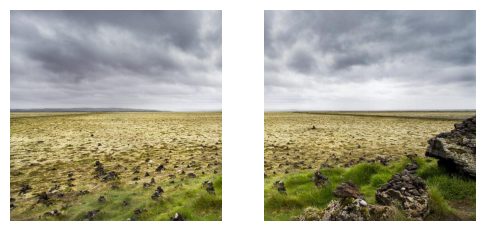

In [10]:
img1 = plt.imread(os.path.join(train_folder, '3_1.jpg'))
img2 = plt.imread(os.path.join(train_folder, '3_2.jpg'))

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

And this is an example of a vertical image that got split:

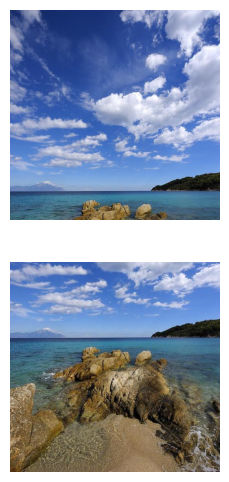

In [11]:
img1 = plt.imread(os.path.join(train_folder, '62_1.jpg'))
img2 = plt.imread(os.path.join(train_folder, '62_2.jpg'))

fig, axes = plt.subplots(2, 1, figsize=(3, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [12]:
print(f"Number of images in train folder: {len(os.listdir(train_folder))}")
print(f"Number of images in validation folder: {len(os.listdir(val_folder))}")
print(f"Number of images in test folder: {len(os.listdir(test_folder))}")

Number of images in train folder: 359
Number of images in validation folder: 116
Number of images in test folder: 117


## Images Preparation and Augmentation (normalization, rotations, labels)

The image loaders are created so that images can be imported while training, one batch at the time, while applying normalization, augmenting the images by rotating them 0°, 90°, 180° or 170°, and generating the one-hot encoded labels accordingly.

This code loads the train and val images from their respective directory, so that the images can be read at runtime while the model is training, avoiding filling up the RAM. The labels will be handled manually during the data augmentation process.

In [13]:
# Load the original datasets
batch_size = 16
train_dataset = image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode=None  # Labels will be handled manually
)

val_dataset = image_dataset_from_directory(
    val_folder,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode=None  # Labels will be handled manually
)

Found 359 files.
Found 116 files.


The next section defines the functions to apply the data augmentation that rotates each image in each batch either 0°, 90°, 180° or 270°, normalizes the image and sets the one-hot encoded labels.

In [14]:
# Number of rotation classes (0°, 90°, 180°, 270°)
num_rotation_classes = 4

# Apply normalization and random rotations to an image and generate the one-hot encoded label
def augment_with_rotation(image):
    image = image / 255.0 # Normalize the image to the [0, 1] range
    rotation = tf.random.uniform([], minval=0, maxval=num_rotation_classes, dtype=tf.int32) # Generate a random rotation index from 0 to num_rotation_classes
    clockwise_rotation = num_rotation_classes - rotation # Reverses the rotation index, since tf.image.rot90 does counterclockwise rotations
    rotated_image = tf.image.rot90(image, k=clockwise_rotation) # Rotate the image clockwise. The 'k' argument determines how many 90° counterclockwise rotations to apply.
    label = tf.one_hot(rotation, depth=num_rotation_classes) # One-hot encode the rotation index (0, 1, 2, or 3 corresponding to 0°, 90°, 180°, 270° rotations)
    return rotated_image, label

# Apply data augmentation to the training dataset
def augment_dataset(dataset):
    return dataset.map( # For each batch of images (x), apply 'tf.map_fn' to process each image
        lambda x: tf.map_fn( # For each image in the batch, apply the 'augment_with_rotation' function
            lambda img: augment_with_rotation(img), # Apply normalization, rotation augmentation and get the one hot encoded label from each image
            x,
            fn_output_signature=(tf.float32, tf.float32) # This specifies the output types of the tf.map_fn operation
        ),
        # Automatically determine the optimal number of parallel calls to process batches more efficiently
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [15]:
# Augment training and validation datasets by applying the rotation-based augmentation
train_augmented = augment_dataset(train_dataset)
val_augmented = augment_dataset(val_dataset)

# Optimize the data pipeline by prefetching data for improved performance during training
train_augmented = train_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)
val_augmented = val_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
# Test the result
for images, labels in train_augmented.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels (one-hot):\n", labels.numpy())

Images shape: (16, 224, 224, 3)
Labels shape: (16, 4)
Labels (one-hot):
 [[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


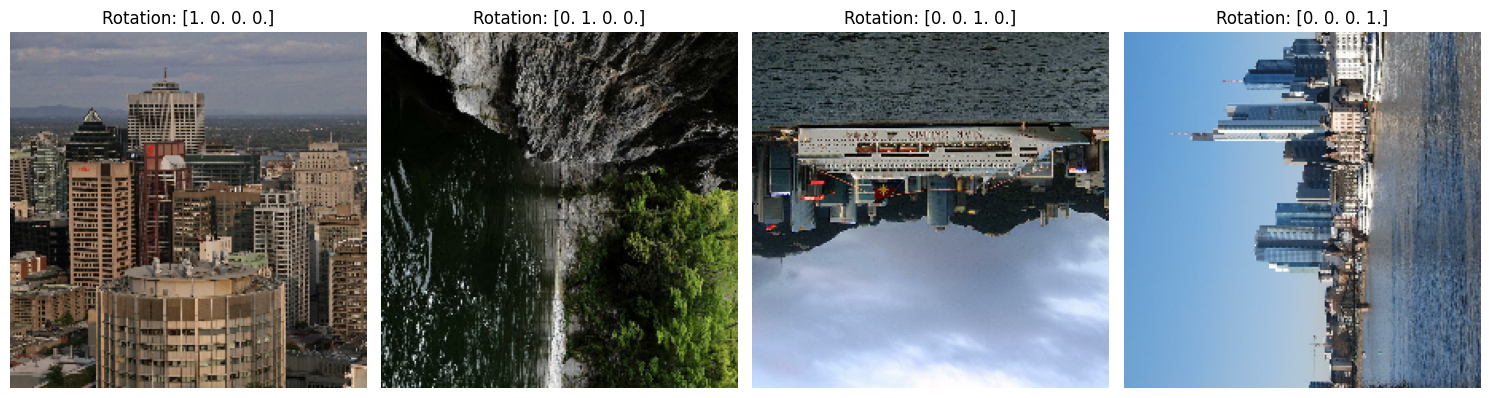

In [17]:
indexes = [2, 9, 0, 5]  # Indexes of images to display

# Set up the figure and subplots
fig, axes = plt.subplots(1, len(indexes), figsize=(15, 5))

# Plot each image with its corresponding label
for i, idx in enumerate(indexes):
    image_in_255 = (images[idx].numpy() * 255).astype("uint8") # Convert image back to 0-255 range and cast to uint8
    axes[i].imshow(image_in_255)
    axes[i].set_title(f"Rotation: {labels[idx]}")  # Display the label as the title
    axes[i].axis("off")

plt.tight_layout()
plt.show()

These outputs confirm that the functions are working as expected, rotating the images randomly and generating the labels accordingly.

## Test Set Preparation

In [18]:
# Define the output folder
test_rotations_folder = os.path.join(dataset_folder, "test_rotations")
os.makedirs(test_rotations_folder, exist_ok=True)

# Create subfolders for each rotation category
rotation_angles = ["0", "90", "180", "270"]
rotation_paths = {angle: os.path.join(test_rotations_folder, angle) for angle in rotation_angles}
for path in rotation_paths.values():
    os.makedirs(path, exist_ok=True)

# Generate_4_rotations function
def generate_4_rotations(image):
    image = image / 255.0  # Normalize the image to the [0, 1] range
    for rotation in range(4):  # Iterate through rotation indices (0, 1, 2, 3)
        clockwise_rotation = 4 - rotation  # Reverse the rotation index for clockwise rotation
        rotated_image = tf.image.rot90(image, k=clockwise_rotation)  # Rotate the image clockwise
        yield rotated_image, rotation

# Process images directly from the folder
for img_name in os.listdir(test_folder):
    img_path = os.path.join(test_folder, img_name)
    if not os.path.isfile(img_path):
        continue  # Skip if it's not a file

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)

    # Generate and save rotated images
    img_name_wo_ext, ext = os.path.splitext(img_name)
    for rotated_img, rotation in generate_4_rotations(img_array):
        img = array_to_img(rotated_img)  # Convert tensor to image
        rotation_suffix = rotation_angles[rotation].split("_")[0]  # Get numeric rotation angle
        new_file_name = f"{img_name_wo_ext}_{rotation_suffix}{ext}"  # Append rotation to the name
        folder = rotation_angles[rotation]  # Get the appropriate folder
        img.save(os.path.join(rotation_paths[folder], new_file_name))  # Save the image

In [19]:
# Check that the test_rotations folders were created correctly
print(f"Number of images in the original test folder: {len(os.listdir(test_folder))}")
for folder_name in sorted(os.listdir(test_rotations_folder), key=lambda x: int(x)): # Converts each folder to int, to sort them in the output
    folder_path = os.path.join(test_rotations_folder, folder_name)
    if os.path.isdir(folder_path):
        file_count = len(os.listdir(folder_path))
        print(f"Number of images in the folder '{folder_name}' in test_rotations: {file_count}")

Number of images in the original test folder: 117
Number of images in the folder '0' in test_rotations: 117
Number of images in the folder '90' in test_rotations: 117
Number of images in the folder '180' in test_rotations: 117
Number of images in the folder '270' in test_rotations: 117


In [20]:
test_dataset = image_dataset_from_directory(
    test_rotations_folder,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical',
    class_names=rotation_angles
)

# Normalize images to [0, 1]
test_dataset = test_dataset.map(lambda x, y: (x / 255.0, y))

Found 468 files belonging to 4 classes.


# Useful Functions
This section contains some functions that will be used multiple times throughout the project.

In [21]:
# Plot the model's history
def plot_history(history):
    plt.figure(figsize=(16, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [22]:
# Load and normalize an image
def load_and_preprocess_image(image_path):
    """
    This function loads an image from the specified path, resizes it to the target size and normalizes its pixel values to be between 0 and 1.
    """
    img = load_img(image_path, target_size=(224, 224))  # Change target size if needed
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return img_array

In [23]:
def predict_labels(test_path, model):
    """
    This function predicts the labels of the given test set and returns the true labels, predicted labels, and mislabeled images.
    """
    label_map = {angle: idx for idx, angle in enumerate(rotation_angles)} # Create a mapping from rotation angles to numerical labels, to apply the same one-hot encoding as the training and validation sets

    # Initialize lists to store true labels, predicted labels, and mislabeled images
    true_labels = []
    predicted_labels = []
    mislabeled_images = []

    # Loop through each rotation angle folder
    for angle in rotation_angles:
        angle_folder = os.path.join(test_path, angle)  # Path to the folder for the current angle

        # Loop through each image in the current angle folder
        for img_name in os.listdir(angle_folder):
            # Process only images with .jpg or .png extensions
            if img_name.endswith('.jpg') or img_name.endswith('.png'):
                img_path = os.path.join(angle_folder, img_name)  # Full path to the image

                # Load and preprocess the image
                img = load_and_preprocess_image(img_path)

                # Get the true label for the image based on its folder (angle)
                true_label = label_map[angle]
                true_labels.append(true_label)

                # Predict the label using the model
                prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)  # Expand dimensions for batch input
                predicted_label = np.argmax(prediction)  # Get the label with the highest probability
                predicted_labels.append(predicted_label)

                # Check if the prediction is incorrect
                if true_label != predicted_label:
                    # Store the mislabeled image path and its true and predicted labels
                    mislabeled_images.append((img_path, angle, rotation_angles[predicted_label]))

    # Return the true labels, predicted labels, and list of mislabeled images
    return np.array(true_labels), np.array(predicted_labels), mislabeled_images


In [32]:
def print_performance_from_predictions(true_labels, predicted_labels, mislabeled_images):
    """
    Evaluates the performance of the model by printing a classification report,
    plotting a confusion matrix and listing mislabeled images, taking the prediction data as input.
    """
    # Print the classification report with precision, recall, F1-score, and support for each class
    print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=rotation_angles))

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rotation_angles, yticklabels=rotation_angles)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print details of mislabeled images for further analysis
    print("\nMislabeled Images:")
    for img_path, true_label, predicted_label in mislabeled_images:
        print(f"Image Path: {img_path} | True Label: {true_label} | Predicted Label: {predicted_label}")

In [25]:
def plot_mislabeled_images(mislabeled_images):
    """
    This function plots all the mislabeled images in a grid.
    Each plot will have as title the name of the image, the true label and the predicted label.
    """
    # Number of images per row
    images_per_row = 4
    num_images = len(mislabeled_images)

    # Create a grid to display images
    plt.figure(figsize=(15, 5 * (num_images // images_per_row + 1)))  # Adjust height based on number of rows

    for i, (img_path, true_label, predicted_label) in enumerate(mislabeled_images):
        # Load the image
        img = load_img(img_path)
        img_array = img_to_array(img)  # Convert to array

        # Create subplot, calculate row and column index
        plt.subplot((num_images // images_per_row) + 1, images_per_row, i + 1)
        plt.imshow(img_array.astype('uint8'))  # Convert array back to uint8 for display
        plt.axis('off')  # Hide axes

        # Title with image name, true label, and predicted label
        img_name = os.path.basename(img_path)  # Get the image name
        title = f"Image: {img_name}\nTrue: {true_label}\nPred: {predicted_label}"
        plt.title(title, fontsize=10)

    # Display the images
    plt.tight_layout()
    plt.show()

In [26]:
def get_or_calculate_evaluation(evaluation_save_path, test_rotations_folder, model):
    """
    This function oads evaluation data if it exists in the given path, otherwise calculates, saves it and returns it.
    """
    if os.path.exists(evaluation_save_path):
        # Load evaluation data
        with open(evaluation_save_path, 'r') as f:
            evaluation_data = json.load(f)
        print("Evaluation data loaded successfully.")

        # Extract variables
        true_labels = np.array(evaluation_data["true_labels"])
        predicted_labels = np.array(evaluation_data["predicted_labels"])
        mislabeled_images = evaluation_data["mislabeled_images"]
    else:
        # Calculate the evaluation data
        true_labels, predicted_labels, mislabeled_images = predict_labels(
            test_rotations_folder, model
        )

        # Prepare data for saving
        evaluation_data = {
            "true_labels": true_labels.tolist(),
            "predicted_labels": predicted_labels.tolist(),
            "mislabeled_images": mislabeled_images
        }

        # Save the evaluation data
        with open(evaluation_save_path, 'w') as f:
            json.dump(evaluation_data, f)
        print("Evaluation data calculated and saved successfully.")

    return true_labels, predicted_labels, mislabeled_images

# Hand-crafted CNN

My first approach was to create a hand-crafted CNN, and train it from scratch.

### Model

This was the best model I could create (and one of the first models I attempted). I have tried adding L1 and L2 regularization, doing more data augmentation through translations, chances in contrast, brightness... but nothing made the model better.

This was the only model that could have a very stable 98% performance, though I did reach 99% once, but given the small amount of images in the test set, it's hard to squeeze more performance. Regardless, 98% accuracy is great.

In [27]:
hand_made_cnn_model_1 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(16, (3, 3), activation='relu', strides=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu', strides=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', strides=(2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_rotation_classes, activation='softmax')
])

hand_made_cnn_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 111, 111, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 111, 111, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 55, 55, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 55, 55, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 27, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 835,940 (3.19 MB)

 Trainable params: 835,716 (3.19 MB)

 Non-trainable params: 224 (896.00 B)

In [28]:
model_save_path = '/content/drive/My Drive/BRC Models/Hand-Made Models/hand_made_cnn_model_1.keras'

if os.path.exists(model_save_path):
    # Load the pre-trained model
    hand_made_cnn_model_1 = load_model(model_save_path)
    print("Model loaded successfully.")

else:
    # Early Stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor (can use 'val_accuracy' if preferred)
        patience=3,          # Number of epochs with no improvement before stopping
        restore_best_weights=True  # Restore the best weights once training stops
    )

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)  # Reduced learning rate
    hand_made_cnn_model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    hand_made_cnn_model_1_history = hand_made_cnn_model_1.fit(
        train_augmented,  # Training dataset
        validation_data=val_augmented,  # Validation dataset
        epochs=25,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    # Create the folder if it doesn't exist already
    model_save_folder = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_folder):
        os.makedirs(model_save_folder)

    # Save the trained model
    hand_made_cnn_model_1.save(model_save_path)

    print("Training complete and model saved.")

Model loaded successfully.


History loaded successfully.


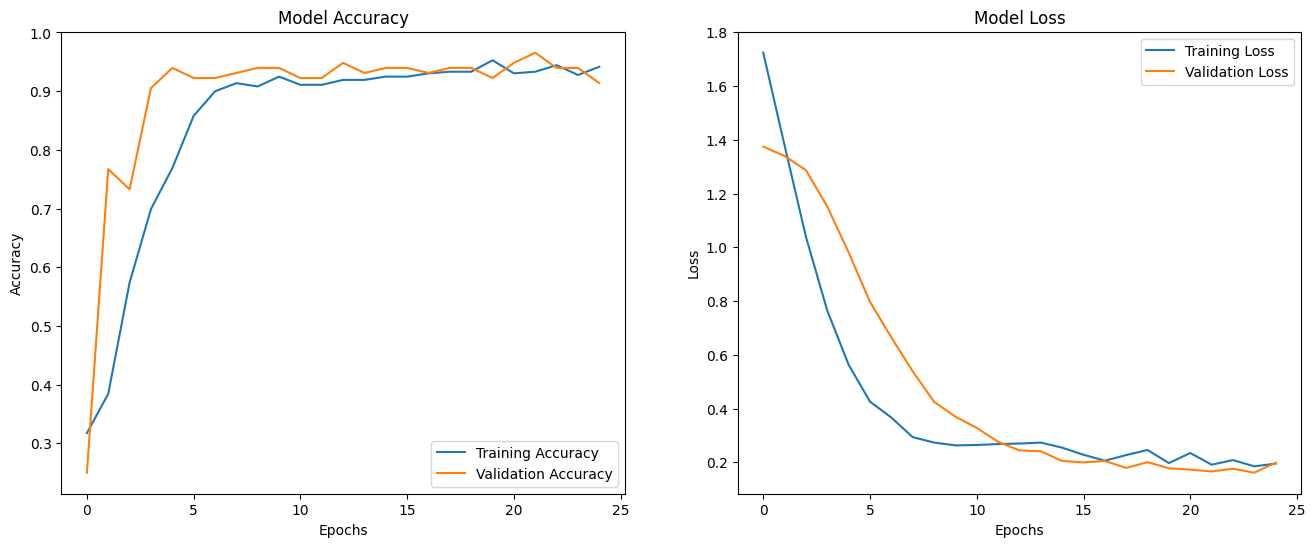

In [29]:
history_save_path = '/content/drive/My Drive/BRC Models/Hand-Made Models/hand_made_cnn_history_1.json'

# Check if history file exists
if os.path.exists(history_save_path):
    # Load history from file
    with open(history_save_path, 'r') as f:
        hand_made_cnn_model_1_history = json.load(f)
    print("History loaded successfully.")
else:
    # Save history after training
    with open(history_save_path, 'w') as f:
        json.dump(hand_made_cnn_model_1_history.history, f)
    print("History saved successfully.")

# Call the function to plot history
plot_history(hand_made_cnn_model_1_history if isinstance(hand_made_cnn_model_1_history, dict) else hand_made_cnn_model_1_history.history)

### Evaluation

In [30]:
true_labels, predicted_labels, mislabeled_images = get_or_calculate_evaluation(
    '/content/drive/My Drive/BRC Models/Hand-Made Models/hand_made_cnn_evaluation_1.json',
    test_rotations_folder,
    hand_made_cnn_model_1
)

Evaluation data loaded successfully.


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       117
          90       0.97      0.99      0.98       117
         180       0.99      0.97      0.98       117
         270       0.97      0.98      0.97       117

    accuracy                           0.98       468
   macro avg       0.98      0.98      0.98       468
weighted avg       0.98      0.98      0.98       468



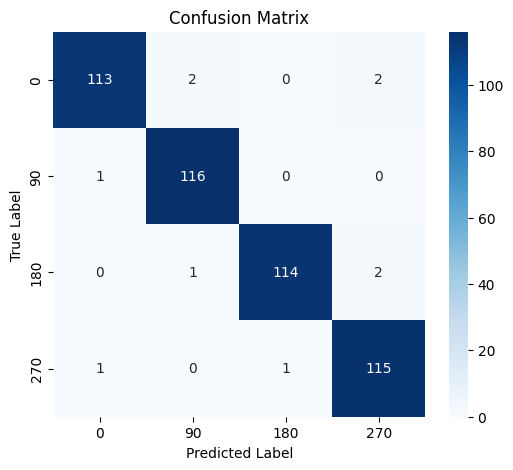


Mislabeled Images:
Image Path: dataset/test_rotations/0/265_2_0.jpg | True Label: 0 | Predicted Label: 90
Image Path: dataset/test_rotations/0/58_1_0.jpg | True Label: 0 | Predicted Label: 270
Image Path: dataset/test_rotations/0/265_1_0.jpg | True Label: 0 | Predicted Label: 90
Image Path: dataset/test_rotations/0/228_2_0.jpg | True Label: 0 | Predicted Label: 270
Image Path: dataset/test_rotations/90/58_1_90.jpg | True Label: 90 | Predicted Label: 0
Image Path: dataset/test_rotations/180/265_1_180.jpg | True Label: 180 | Predicted Label: 270
Image Path: dataset/test_rotations/180/265_2_180.jpg | True Label: 180 | Predicted Label: 270
Image Path: dataset/test_rotations/180/58_1_180.jpg | True Label: 180 | Predicted Label: 90
Image Path: dataset/test_rotations/270/58_1_270.jpg | True Label: 270 | Predicted Label: 180
Image Path: dataset/test_rotations/270/265_1_270.jpg | True Label: 270 | Predicted Label: 0


In [33]:
# Evaluate the model by printing the classification report, plotting confusion matrix, and printing mislabeled images
print_performance_from_predictions(true_labels, predicted_labels, mislabeled_images)

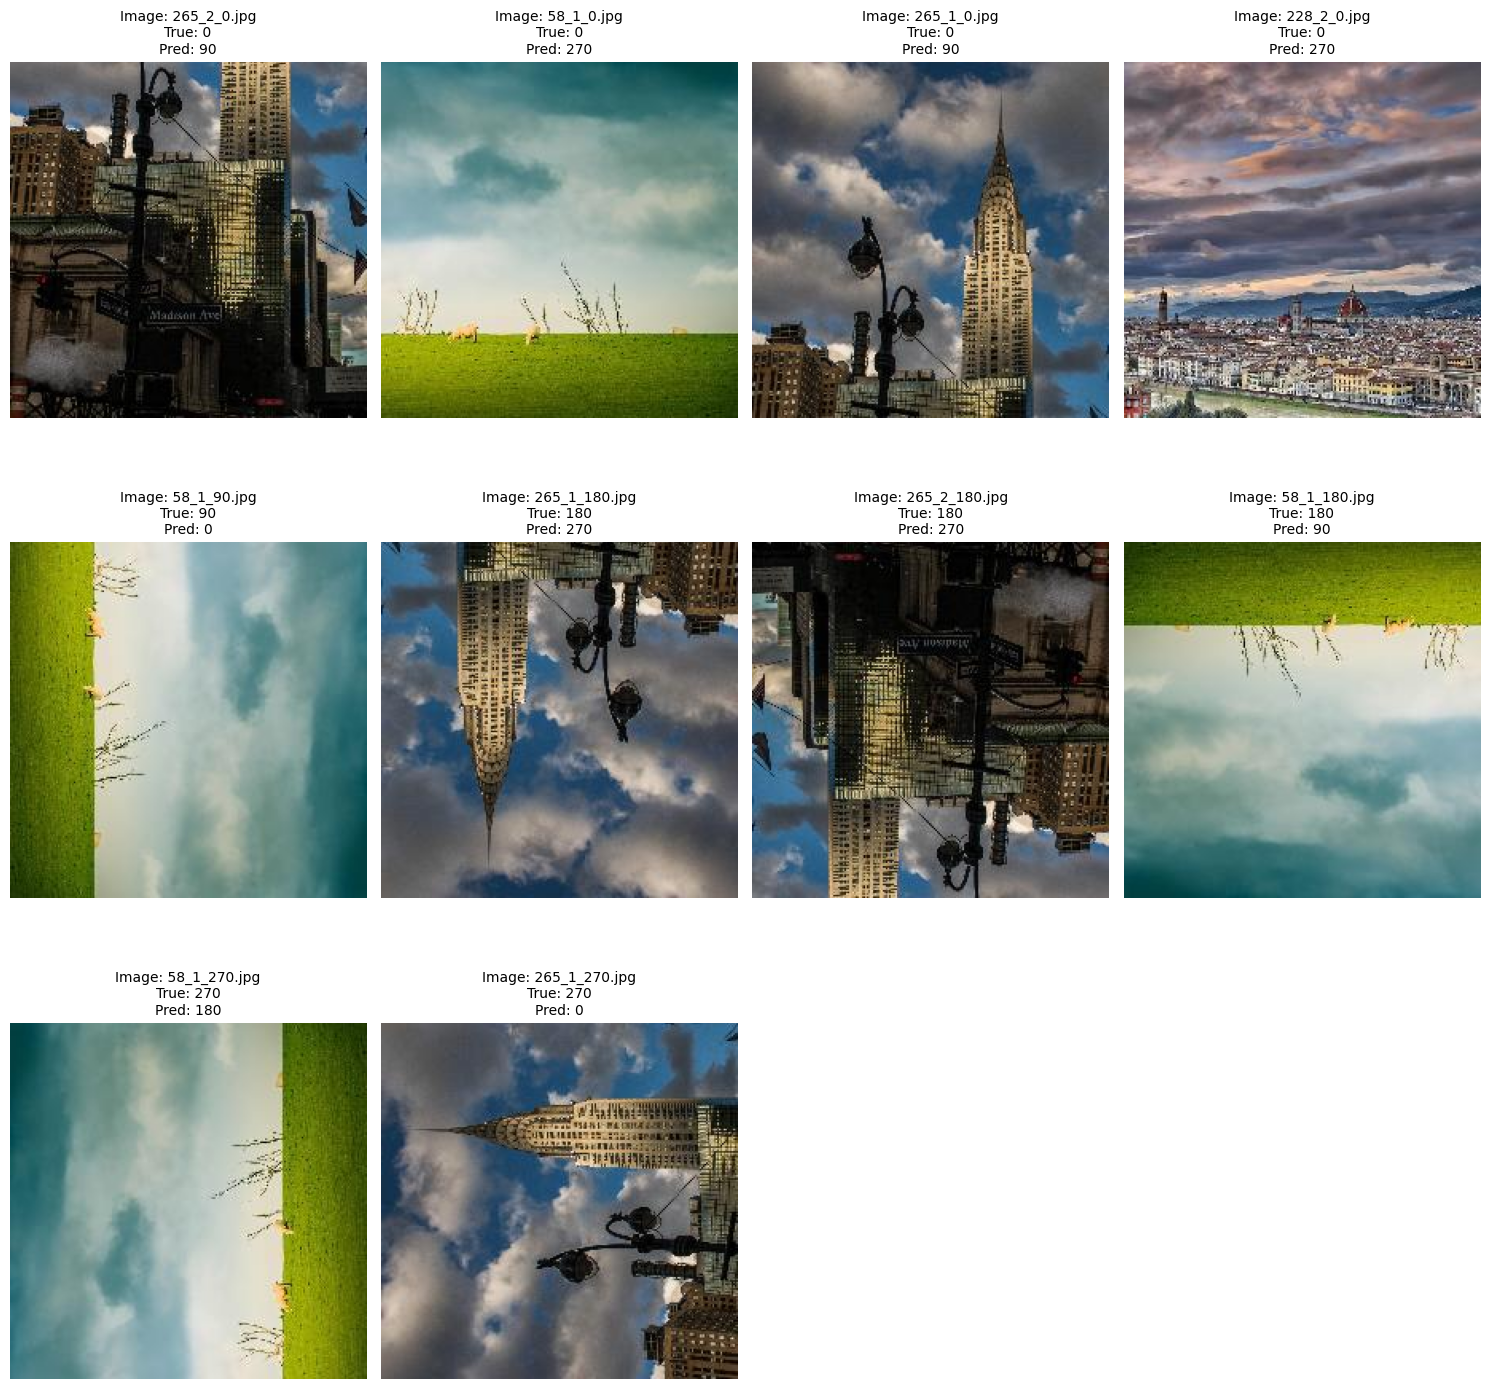

In [34]:
plot_mislabeled_images(mislabeled_images)

It is very important to manually look at the mistakes that the model made.

It's clear that the model isn't making mistakes on a particular rotation angle for example, but it's mis-predicting the labels of mainly 2 pictures. This indicates a lack of generalization of the model, given by the low amount of images in the dataset.

# More for later

In [ ]:
# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomContrast(0.1),  # Adjust contrast by up to 20%
    layers.RandomBrightness(0.1),  # Adjust brightness by up to 20%
    layers.RandomTranslation(0.1, 0.1),  # Translate images by up to 10% in height and width
])

# Apply data augmentation to the training dataset
def preprocess_and_augment(image):
    image = data_augmentation(image)
    return image

In [ ]:
train_dataset = image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode=None  # Labels will be handled manually
).map(preprocess_and_augment)

In [ ]:
# Augment training and validation datasets by applying the rotation-based augmentation
train_augmented = augment_dataset(train_dataset)

# Optimize the data pipeline by prefetching data for improved performance during training
train_augmented = train_augmented.prefetch(buffer_size=tf.data.AUTOTUNE)